In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
RESULTS_DIR = "./outputs/results"
!ls {RESULTS_DIR}

segmentation_by_class.csv  wall_junctions_no_class.csv
segmentation_global.csv    wall_junctions_per_class.csv
wall_junctions_mixed.csv


This notebook concerns the evaluation of the model's results.

In [3]:
def color(data, cmap="Greens"):
    return data.style.background_gradient(cmap=cmap, low=0, high=1.0, axis=0)

## Global segmentation results

In [4]:
global_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_global.csv")
color(global_seg_results)

,name,Overall Acc,Mean Acc,FreqW Acc,Mean IoU
0,Room segmentation,0.825413,0.695570,0.716768,0.572802
1,Room polygon segmentation,0.773188,0.617211,0.636310,0.494661
2,Icon segmentation,0.975057,0.602279,0.953139,0.549512
3,Icon polygon segmentation,0.966732,0.461216,0.937448,0.423070


### Class segmentation results

In [5]:
class_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_by_class.csv")
room_mask = class_seg_results.name.isin(["Room segmentation", "Room polygon segmentation"])
room_seg_results, icon_seg_results = class_seg_results[room_mask], class_seg_results[~room_mask]

<AxesSubplot:title={'center':'Room Class Acc discriminated by class'}, xlabel='Class Acc', ylabel='class_names'>

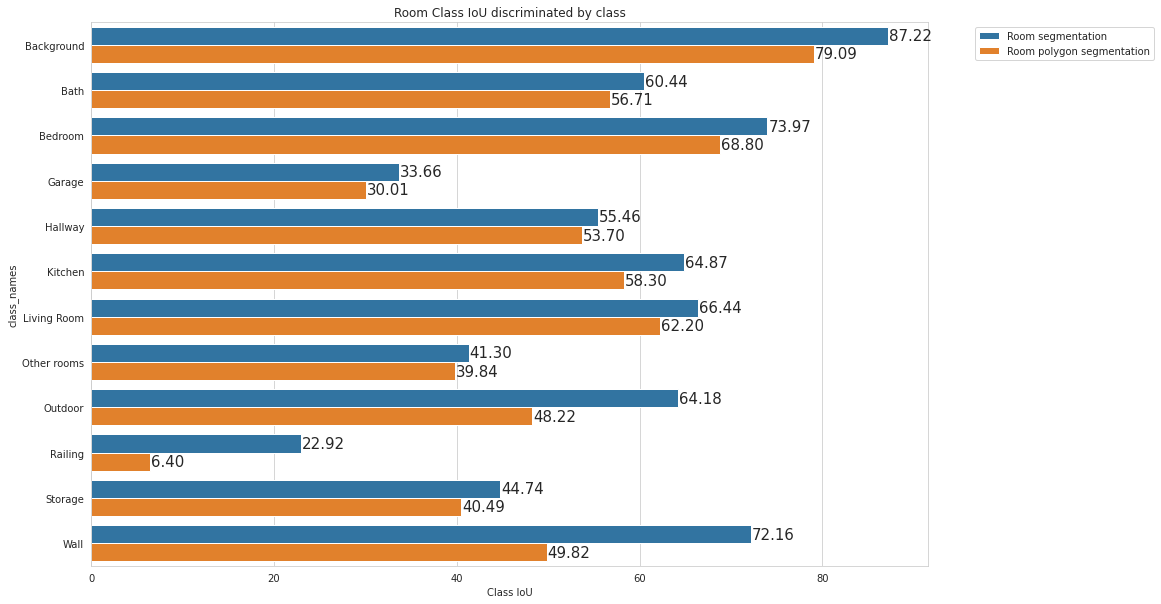

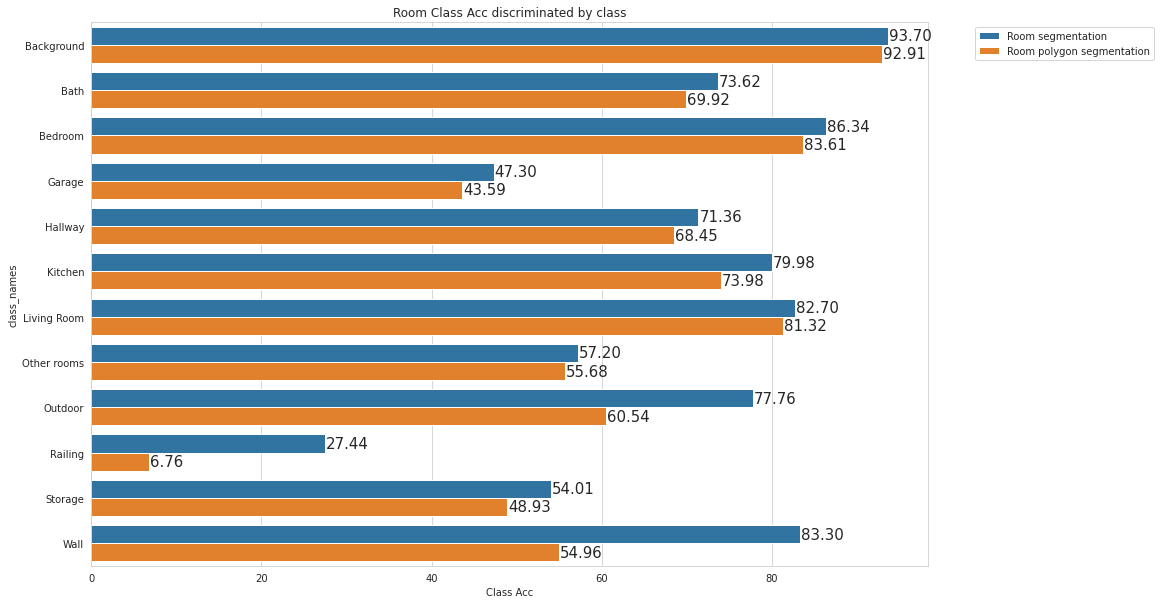

In [6]:
def plot_segmentation_results(data, metric, figsize=(15, 10)):
    data = data.sort_values("class_names")
    plt.figure(figsize=figsize)
    plt.title(f"Room {metric} discriminated by class")
    plt.ylabel("Class names")
    
    splot = sns.barplot(data=data, x=metric, y="class_names", hue="name", orient="h")

    for p in splot.patches:

        splot.annotate(
            format(p.get_width(), '.2f'), 
            xy=(p.get_width(), p.get_y()+p.get_height()/2),
            ha = 'left',
            va = 'center', 
            size=15, 
            xytext = (1, 0),
            textcoords = 'offset points')
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return splot
        
    
plot_segmentation_results(data=room_seg_results, metric="Class IoU")
plot_segmentation_results(data=room_seg_results, metric="Class Acc")

### Icon segmentation results

<AxesSubplot:title={'center':'Room Class Acc discriminated by class'}, xlabel='Class Acc', ylabel='class_names'>

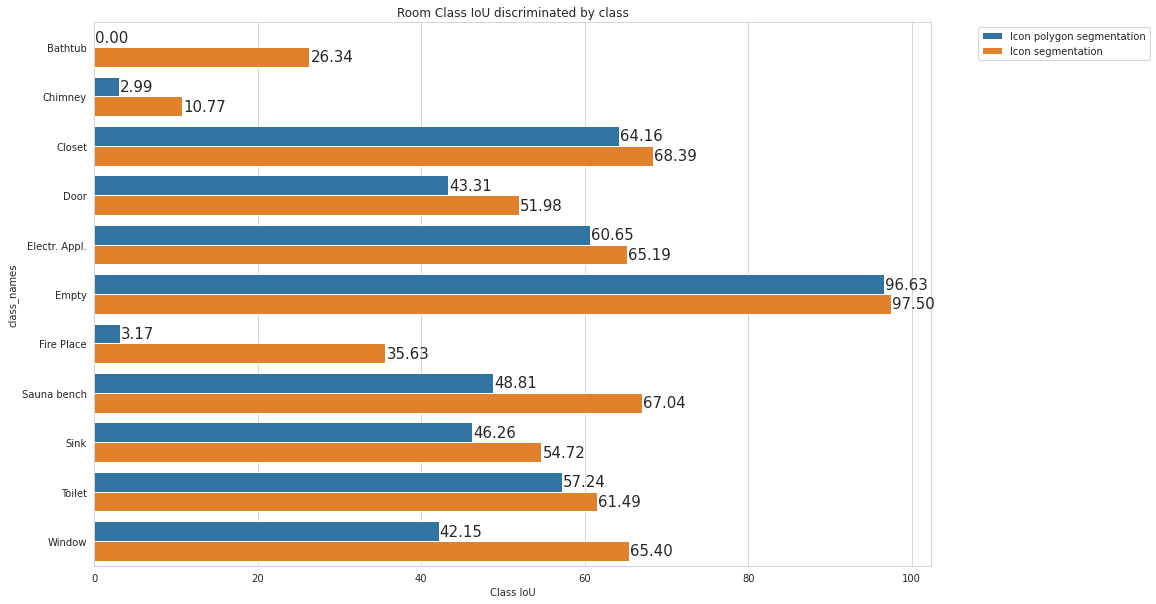

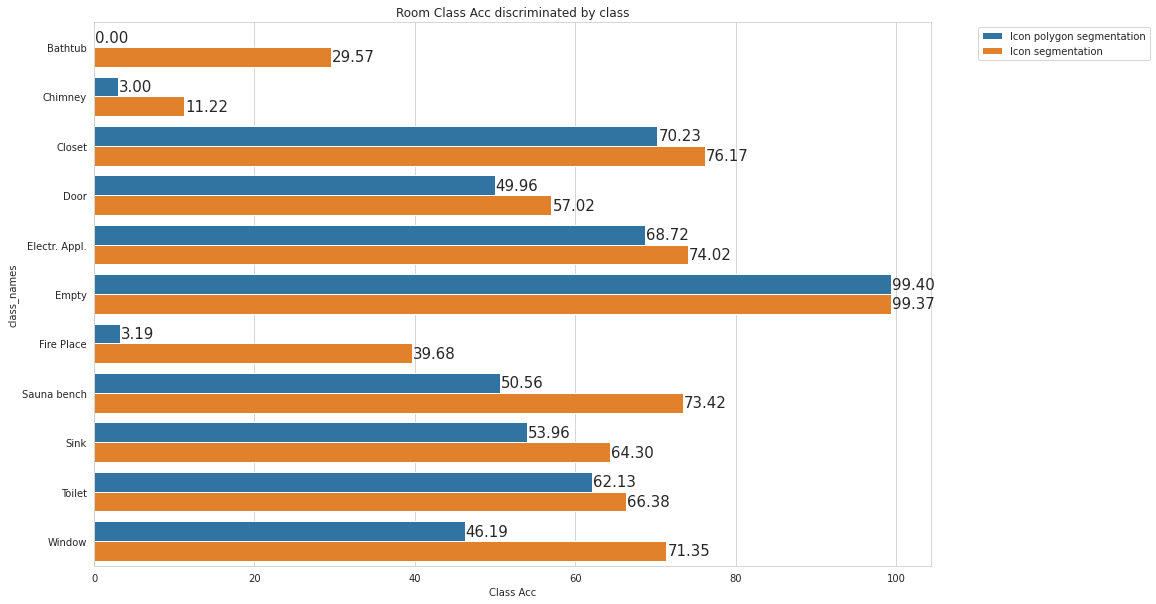

In [7]:
plot_segmentation_results(data=icon_seg_results, metric="Class IoU")
plot_segmentation_results(data=icon_seg_results, metric="Class Acc")

## Junctions per class

In [8]:
def plot_per_class(
    data: pd.DataFrame,
    by: str,
    x: str,
    y: str,
    n_cols: int=3,
    figsize=(15, 15),
    dpi=150,
    **kwargs
):
    n_plots = data[by].nunique()

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=figsize, dpi=dpi)

    for k, by_category in enumerate(data[by].unique()):
        d = data[(data[by] == by_category)]
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x=x, y=y, ax=ax, **kwargs)
        ax.set_title(f"({by}={by_category}) {y}-{x} curve")

    plt.tight_layout()

In [9]:
junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_per_class.csv", index_col=0)
overall_mask = junctions["class"] == "overall"

junctions_overall = junctions[overall_mask]
junctions_by_class = junctions[~overall_mask]

Text(0.5, 1.0, 'Precision-Recall curve for Junctions *overall*')

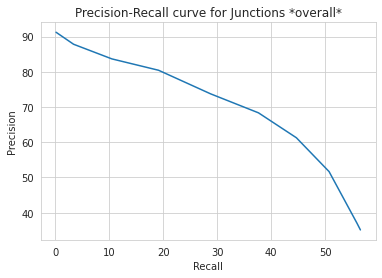

In [10]:
sns.lineplot(data=junctions_overall, x="Recall", y="Precision")
plt.title("Precision-Recall curve for Junctions *overall*")

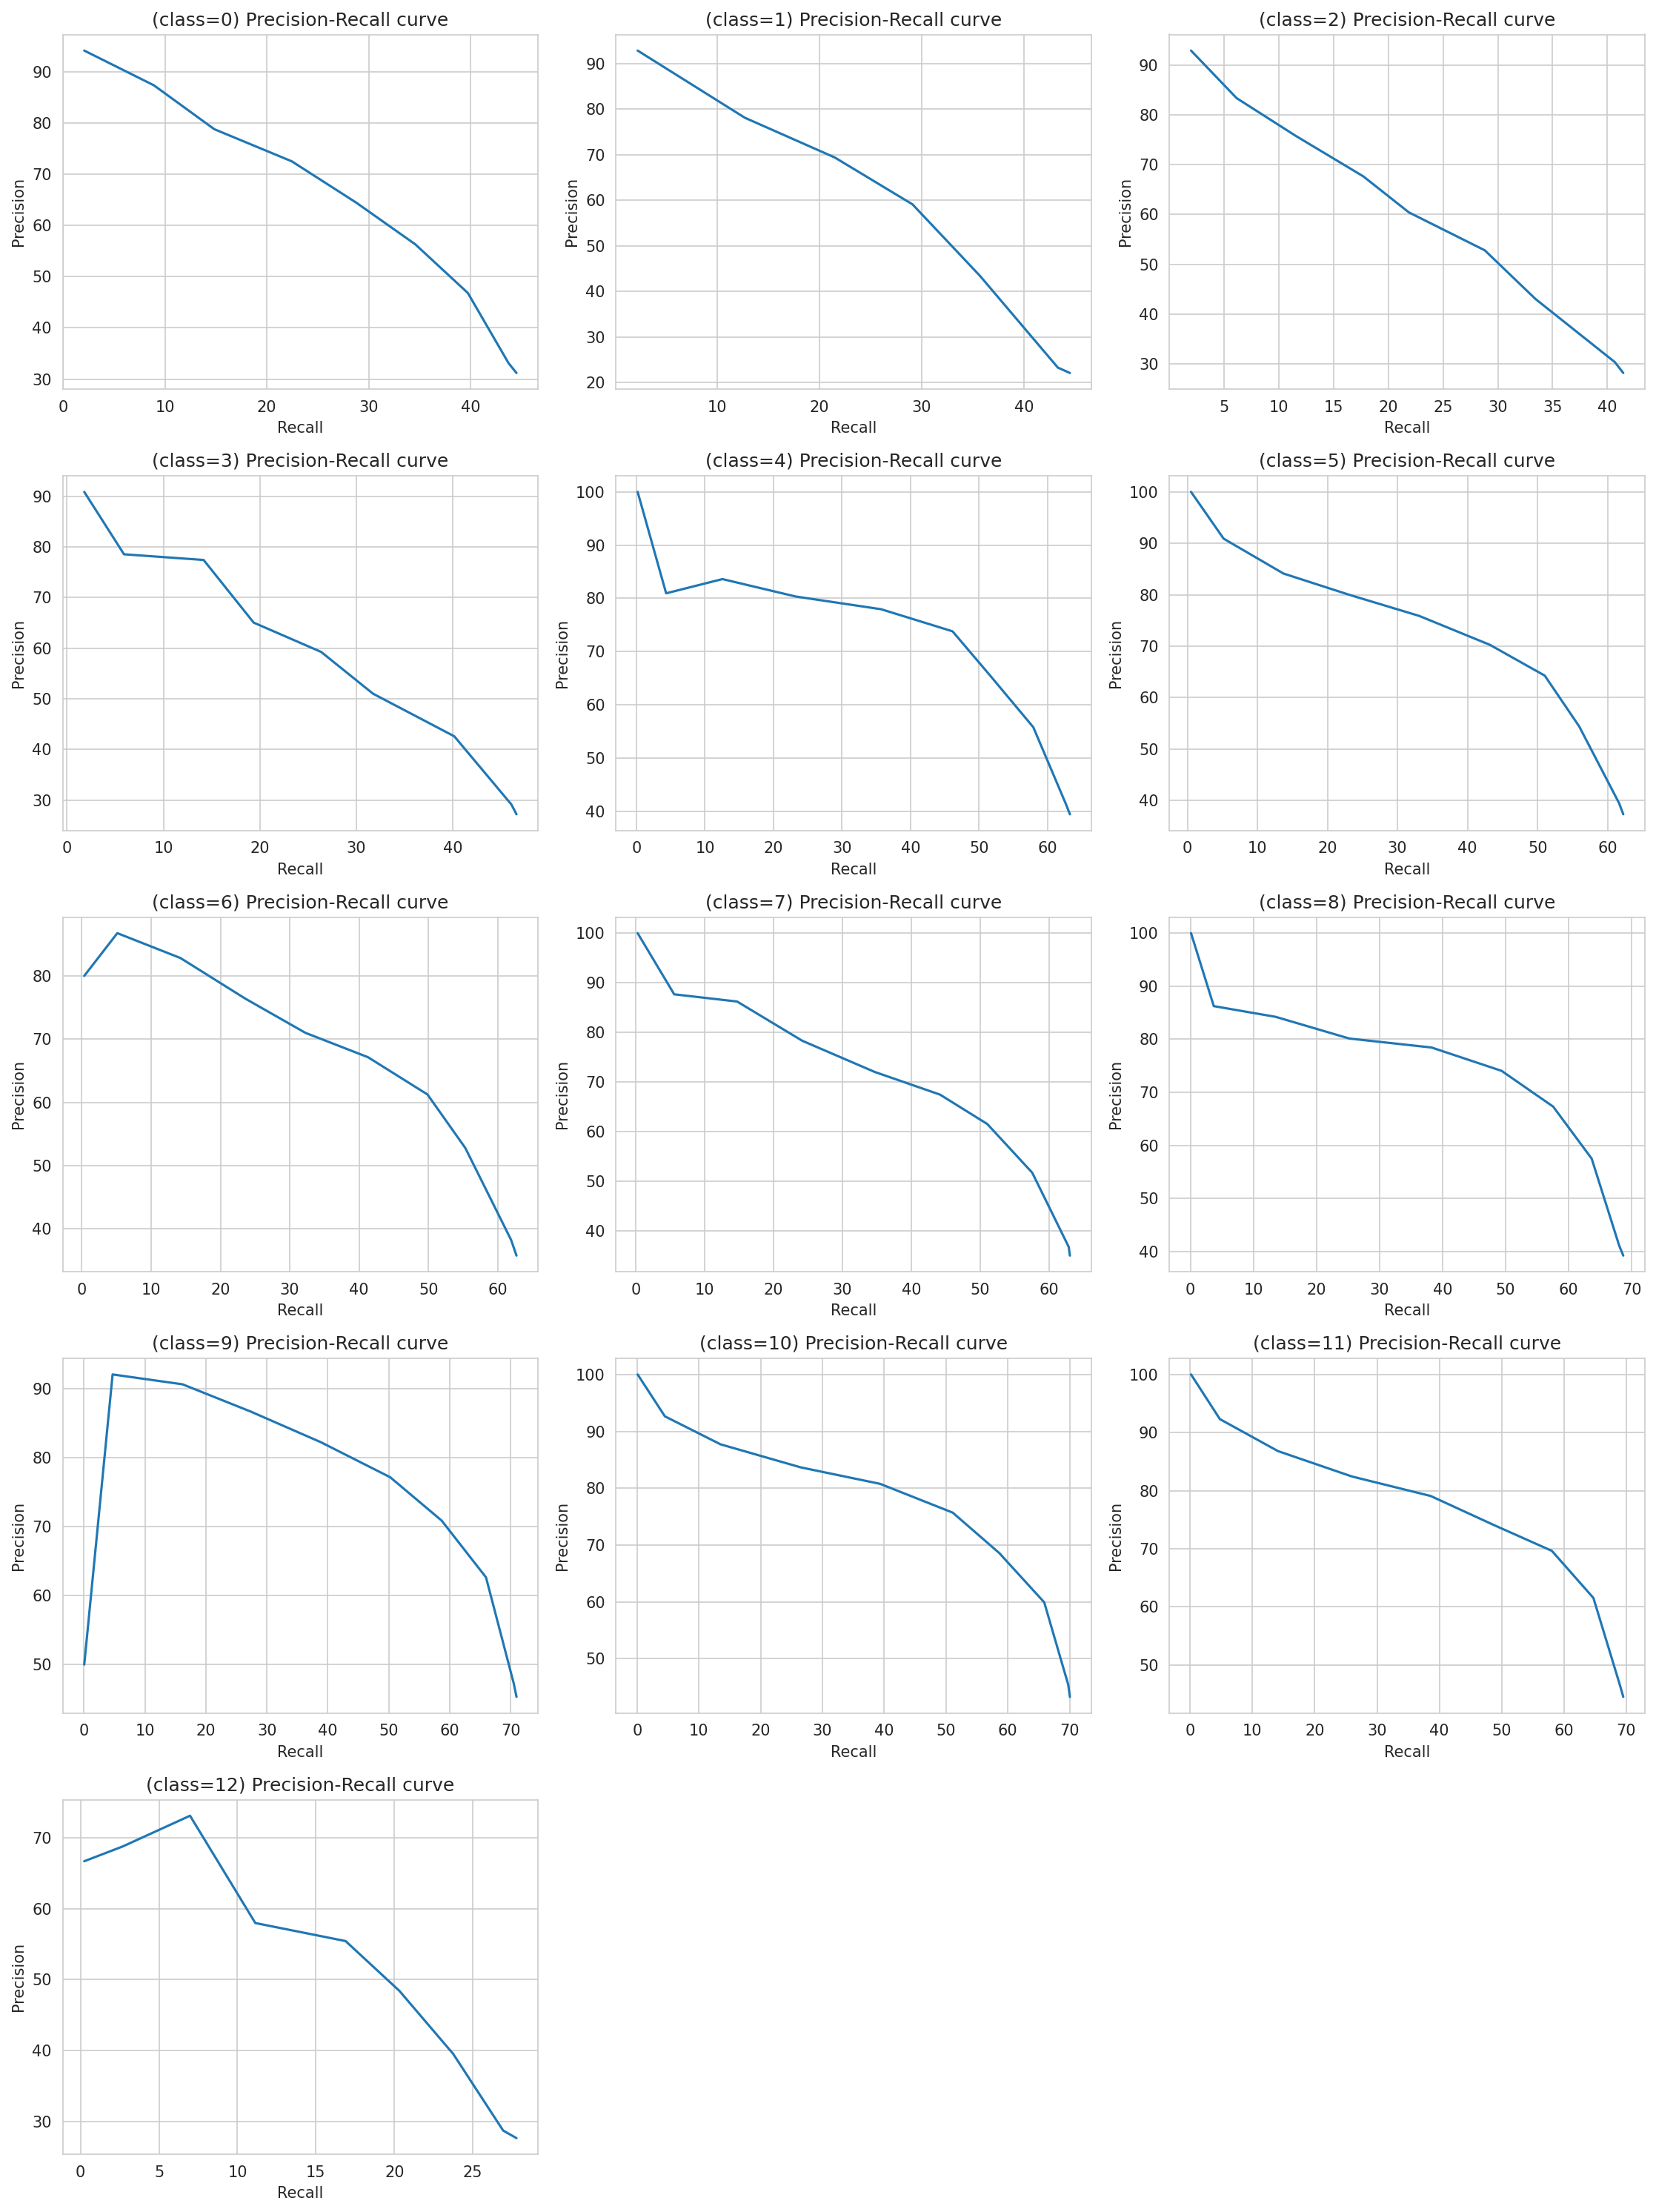

In [11]:
plot_per_class(junctions_by_class, x="Recall", y="Precision", by="class", figsize=(15, 20))

In [12]:
junctions_by_class[junctions_by_class["class"] == "5"]

,class,Recall,Precision
threshold,,,
0,5,62.24,37.33
10,5,61.64,39.50
20,5,55.95,54.40
30,5,51.03,64.28
40,5,43.19,70.27
50,5,33.10,75.89
60,5,23.10,80.00
70,5,13.71,84.13
80,5,5.17,90.91


## Wall junctions (no class)

Text(0.5, 1.0, 'Precision-Recall curve for Junctions (no class)')

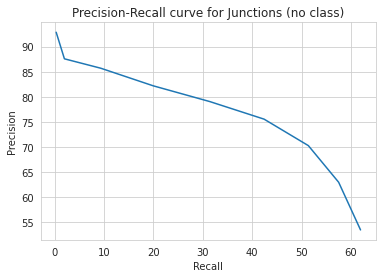

In [13]:
junctions_no_class = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_no_class.csv")
sns.lineplot(data=junctions_no_class, x="Recall", y="Precision")
plt.title("Precision-Recall curve for Junctions (no class)")

## Mixed Junctions

In [14]:
def normalize(data):
    total_gt = data.sum()
    return round(data/total_gt, 4)


def confusion_matrix_by_threshold(data, figsize=(15, 10)):
    for threshold in data.threshold.unique():
        d = data[data.threshold == threshold].copy()
        d.drop(["threshold"], axis=1, inplace=True)

        # Sanity check
        d = d.apply(normalize, axis=1)

        plt.figure(figsize=figsize)
        plt.title(f"Threshold={threshold}")
        sns.heatmap(d, cmap="coolwarm", vmin=0, vmax=1, annot=True)
        plt.show()

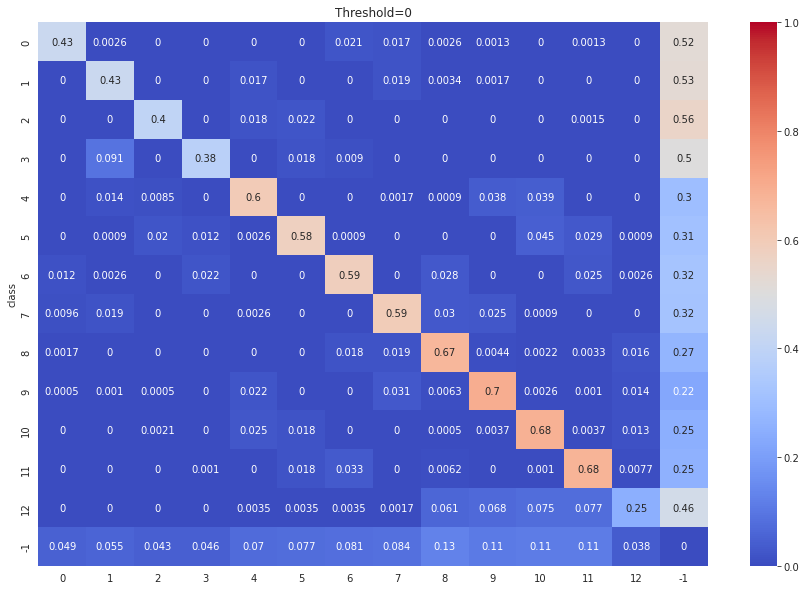

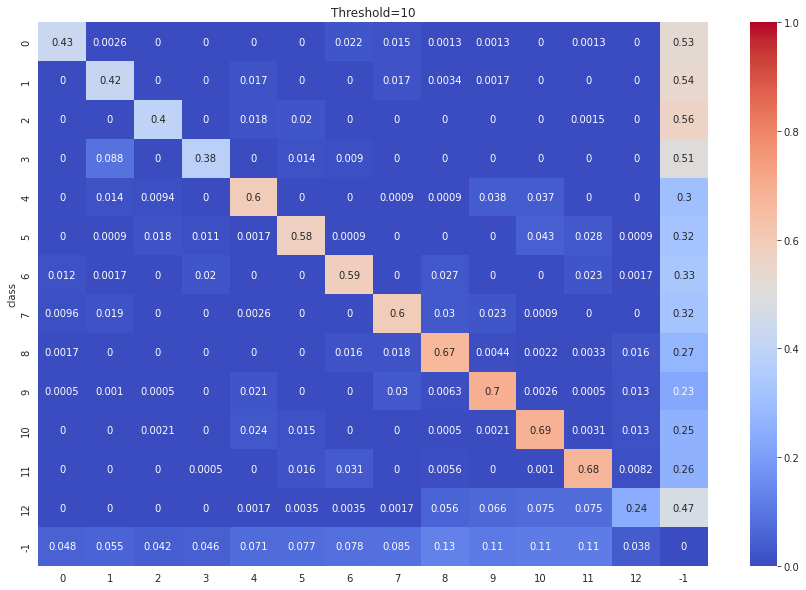

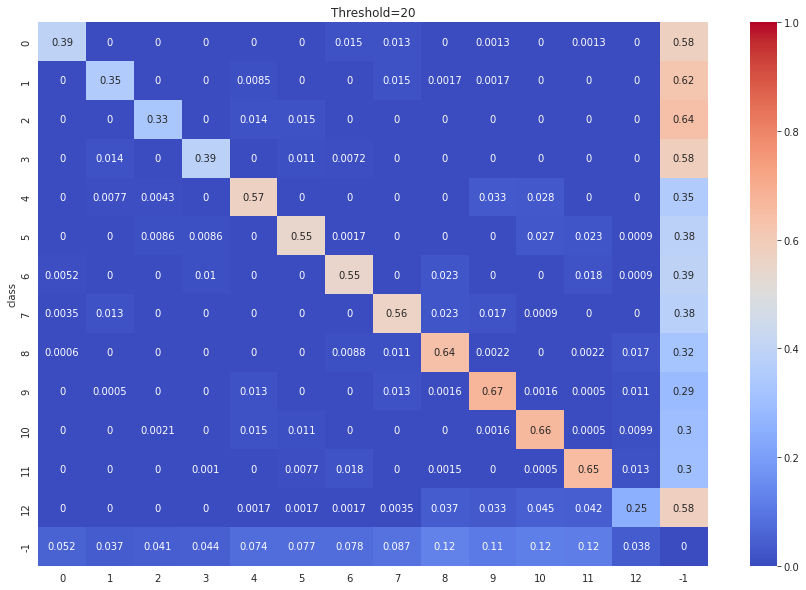

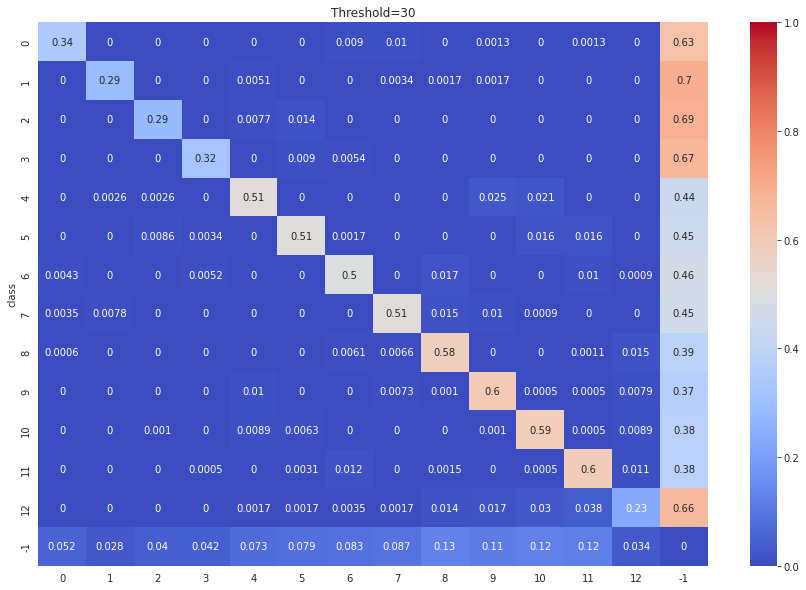

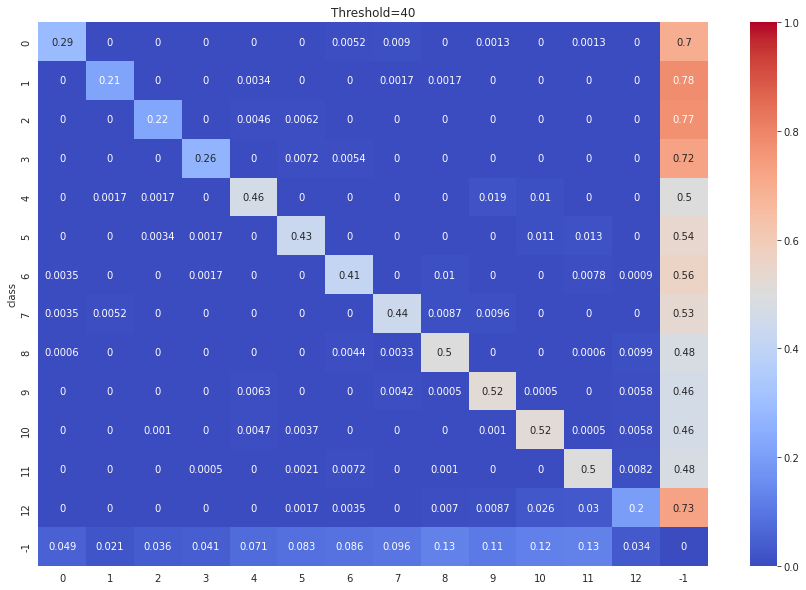

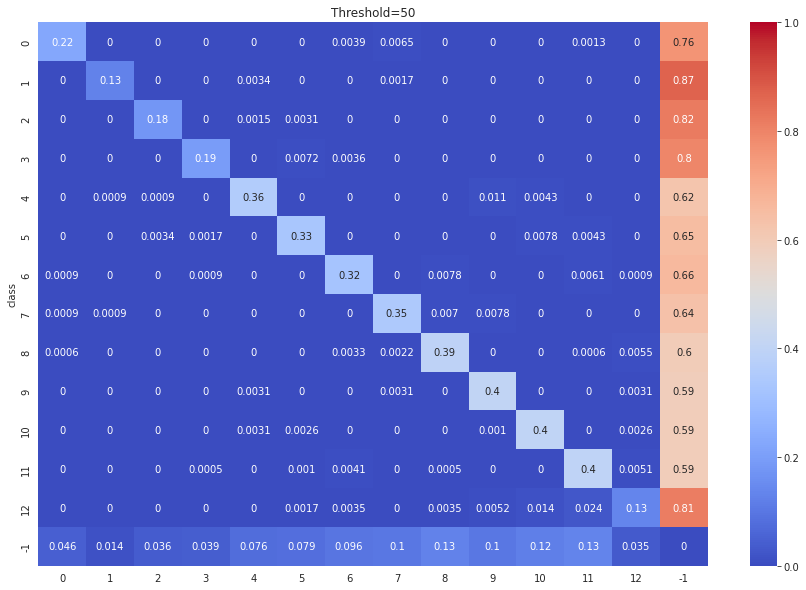

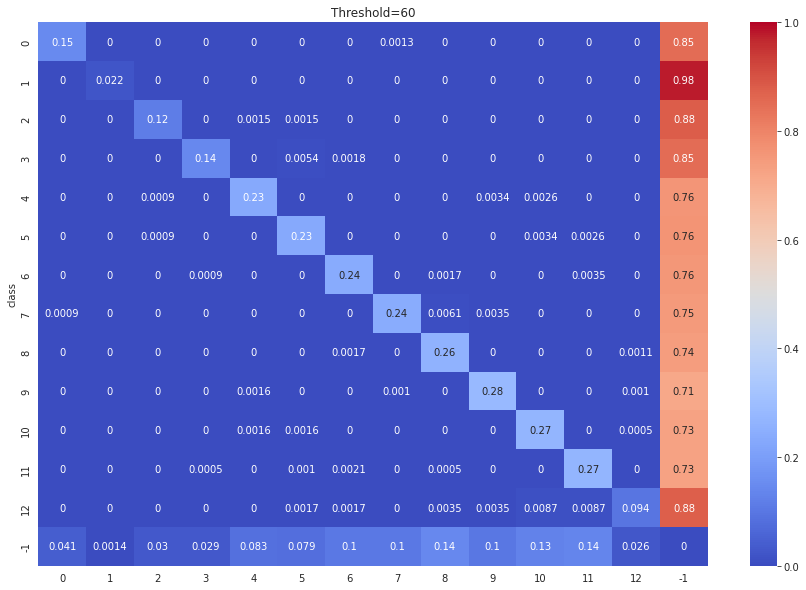

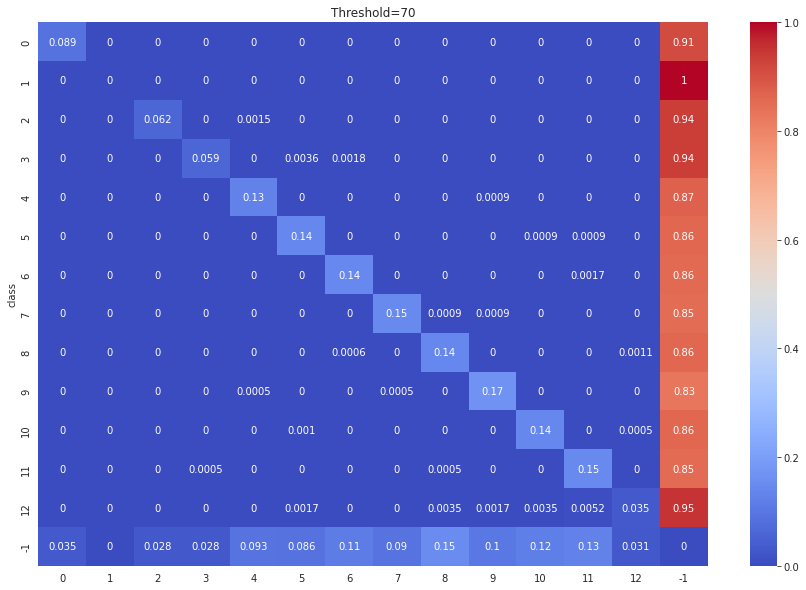

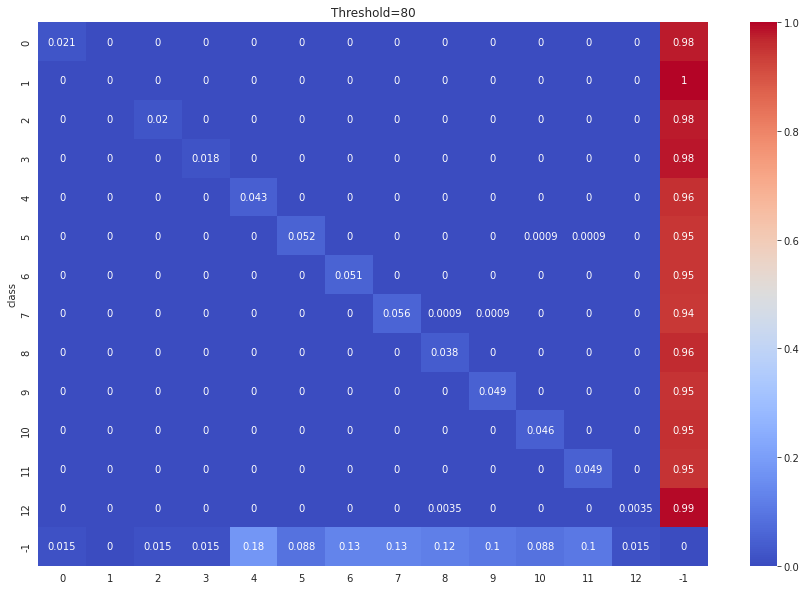

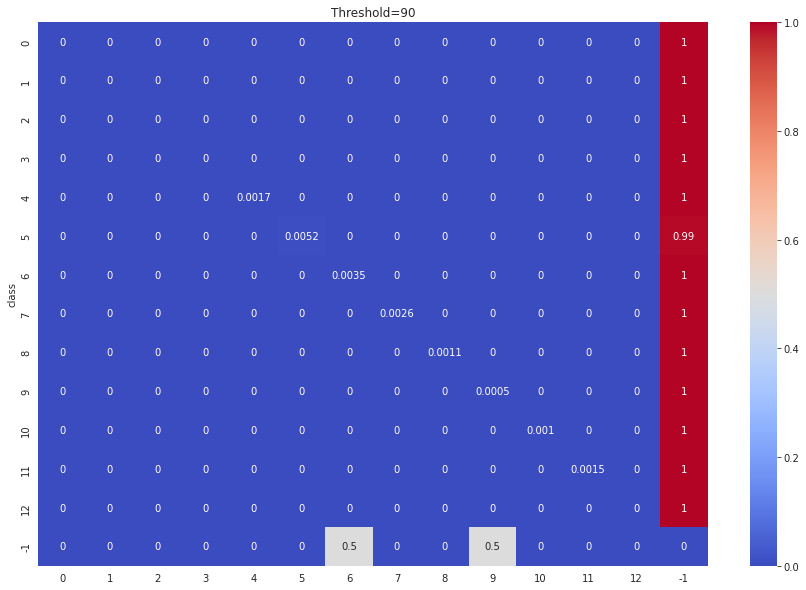

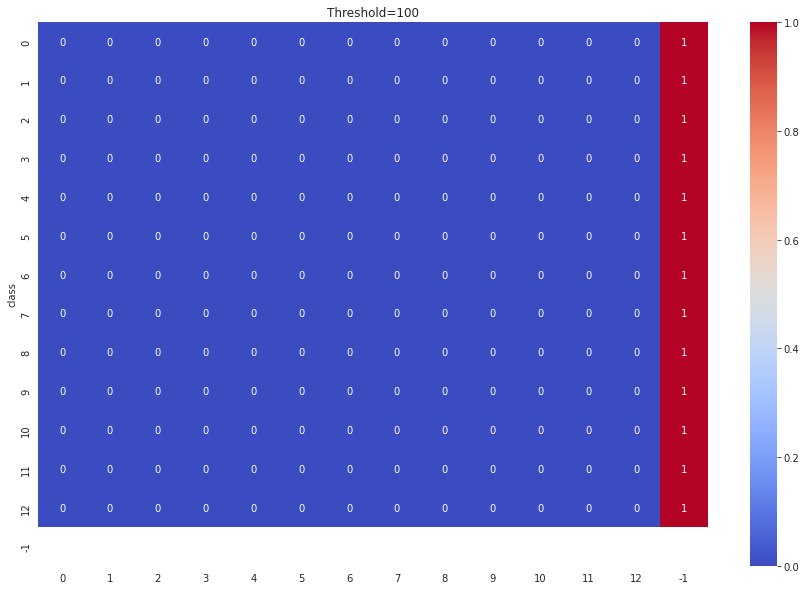

In [15]:
mixed_junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv").set_index("class")
confusion_matrix_by_threshold(mixed_junctions)